# Using our own deeper network

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\tensorf

In [2]:
TENSORBOARD_SUMMARIES_DIR = 'tmp/svhn_classifier3_logs'

In [3]:
#loading data
f = h5py.File('SVHN_grey_norm_ttv.h5','r')

X_train = f['X_train'][:]
X_test = f['X_test'][:]
X_val = f['X_val'][:]
y_train = f['y_train'][:]
y_test = f['y_test'][:]
y_val = f['y_val'][:]

f.close()

print("Training data: ", X_train.shape, y_train.shape)
print("Testing data: ", X_test.shape, y_test.shape)
print("Validation data: ", X_val.shape, y_val.shape)

Training data:  (63733, 32, 32, 1) (63733, 10)
Testing data:  (26032, 32, 32, 1) (26032, 10)
Validation data:  (9524, 32, 32, 1) (9524, 10)


In [4]:
#creating log directory
def prepare_log_dir():
    '''Clears the log file then creates new directory to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

In [5]:
#creating next batch for training
def batch_gen(X,Y,batchsize = 512):
    for i in np.arange(0, Y.shape[0], batchsize):
        end = min(X.shape[0], i+batchsize)
        yield(X[i:end,:,:,:],Y[i:end,:])

In [6]:
#create placeholder for X and y and dropout rate
size = 32*32
tf.logging.set_verbosity(tf.logging.INFO)

x = tf.placeholder(tf.float32, shape = [None,32,32,1], name = 'input_data')
y = tf.placeholder(tf.float32, shape = [None,10], name = 'input_labels')
y_cls = tf.argmax(y,1)

discard_rate = tf.placeholder(tf.float32, name='discard_rate')
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [7]:
#our network [input]->[conv]->[conv]->[pooling]->[conv]->[conv]->[pooling]->[conv]->[conv]->[pooling]->[dropout]->
#[fc+relu]->[fc+relu]->[fc+relu]->[softmax]
def cnn_model(features):
    #input layer
    input_layer = tf.reshape(features, [-1,32,32,1], name = 'reshaped_input')
    
    #convolution layer 1
    conv_layer_1 = tf.layers.conv2d(inputs = input_layer, filters = 48, kernel_size = [5,5],
                                   padding = "same", activation = tf.nn.relu)
    
    #convolution layer 2
    
    conv_layer_2 = tf.layers.conv2d(inputs = conv_layer_1, filters = 48, kernel_size = [5,5],
                                   padding = "same", activation = tf.nn.relu)
    
    #pooling layer 1
    pool_layer_1 = tf.layers.max_pooling2d(inputs = conv_layer_2, pool_size = [2,2], strides = 2)
    
    #convolution layer 3
    conv_layer_3 = tf.layers.conv2d(inputs = pool_layer_1, filters = 64, kernel_size = [5,5],
                                   padding = "same", activation = tf.nn.relu)
    
    #convolution layer 4
    conv_layer_4 = tf.layers.conv2d(inputs = conv_layer_3, filters = 64, kernel_size = [5,5],
                                   padding = "same", activation = tf.nn.relu)
    
    #pooling layer 2
    pool_layer_2 = tf.layers.max_pooling2d(inputs = conv_layer_4, pool_size = [2,2], strides = 2)
    
    #convolution layer 5
    conv_layer_5 = tf.layers.conv2d(inputs = pool_layer_2, filters = 128, kernel_size = [5,5],
                                   padding = "same", activation = tf.nn.relu)
    
    #convolution layer 6
    
    conv_layer_6 = tf.layers.conv2d(inputs = conv_layer_5, filters = 128, kernel_size = [5,5],
                                   padding = "same", activation = tf.nn.relu)
    
    #pooling layer 3
    pool_layer_3 = tf.layers.max_pooling2d(inputs = conv_layer_6, pool_size = [2,2], strides = 2)
    
    #fully connected layer
    #flatten
    flat_layer = tf.reshape(pool_layer_3, [-1, 4 * 4 * 128])
    
    #dense layer 1
    dense_layer_1 = tf.layers.dense(inputs = flat_layer, units = 256, activation = tf.nn.relu)
    
    #dense layer 2
    dense_layer_2 = tf.layers.dense(inputs = dense_layer_1, units = 256, activation = tf.nn.relu)
    
    #dense layer 3
    dense_layer_3 = tf.layers.dense(inputs = dense_layer_2, units = 256, activation = tf.nn.relu)
    
    #dropout layer
    dropout_layer = tf.layers.dropout(inputs = dense_layer_3, rate = discard_rate)
    
    #logits layer
    logits = tf.layers.dense(inputs = dropout_layer, units = 10)
    
    return logits
    
    

In [8]:
#initialize variables for training
epochs = 4
num_examples = X_train.shape[0]

In [9]:
prepare_log_dir()

In [10]:
#predictor model
prediction = cnn_model(x)
prediction_cls = tf.argmax(prediction,1)

#softmax loss
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels = y, logits = prediction))

#We use Adam Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.


In [11]:
#Prediction and accuracy
correct_label = tf.equal(prediction_cls, y_cls)

accuracy = tf.reduce_mean(tf.cast(correct_label, tf.float32))

In [12]:
#initializing tensorflow session
sesh = tf.Session()
sesh.run(tf.global_variables_initializer())

In [13]:
#SAVER OBJECT
saver = tf.train.Saver()

save_dir = 'checkpnts/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_convnet_grey_our_v2')

In [15]:
#training
#batch size
batch_size = 512
#dropout rate
dropout_rate = 0.3

loss_train = []
loss_val = []
#start training
t0 = time.time()
for epoch in range(epochs):
    print("Starting to train the model")
    epoch_loss = 0
    print("Epoch", epoch+1,'\n')
    step = 0
    #training
    for (ex, ey) in batch_gen(X_train, y_train, 512):
        _, train_acc, l = sesh.run([optimizer, accuracy, loss],feed_dict = {x: ex, y: ey, discard_rate: dropout_rate})
        loss_train.append(l)
        
        if (step % 20 == 0):
            print("Step", step)
            print("batchloss", l)
            print("accuracy", train_acc*100,'%')
            
            #validation
            acc = 0
            for (ex,ey) in batch_gen(X_val, y_val, 512):
                correct, lc= sesh.run([correct_label,loss],feed_dict = {x:ex, y:ey, discard_rate: dropout_rate})
                loss_val.append(lc)
                acc += np.sum(correct[correct==True])
            print("Validation accuracy: ", acc*100/y_val.shape[0],'%')
        step += 1
        
    print(" Trained Epoch ", epoch+1, "/",epochs)

#testing
acctest = 0.0
for (ex,ey) in batch_gen(X_test, y_test, 512):
    correct = sesh.run([correct_label], feed_dict={x: ex, y: ey, discard_rate: 0.0})
    acctest+= np.sum(correct[correct == True])
print('Test Accuracy :' , acctest*100.0/y_test.shape[0], '%')

        
    

Starting to train the model
Epoch 1 

Step 0
batchloss 2.2598906
accuracy 17.7734375 %
Validation accuracy:  19.361612767744646 %
Step 20
batchloss 2.255509
accuracy 17.578125 %
Validation accuracy:  19.361612767744646 %
Step 40
batchloss 2.2578843
accuracy 20.8984375 %
Validation accuracy:  20.00209995800084 %
Step 60
batchloss 2.076266
accuracy 27.9296875 %
Validation accuracy:  28.73792524149517 %
Step 80
batchloss 1.7359385
accuracy 41.015625 %
Validation accuracy:  47.31205375892482 %
Step 100
batchloss 1.2739391
accuracy 55.2734375 %
Validation accuracy:  57.087358252834946 %
Step 120
batchloss 0.89835083
accuracy 66.6015625 %
Validation accuracy:  69.21461570768585 %
 Trained Epoch  1 / 4
Starting to train the model
Epoch 2 

Step 0
batchloss 0.969795
accuracy 70.1171875 %
Validation accuracy:  70.76858462830744 %
Step 20
batchloss 0.7178001
accuracy 77.1484375 %
Validation accuracy:  77.89794204115918 %
Step 40
batchloss 0.63136077
accuracy 78.515625 %
Validation accuracy:  82.

In [16]:
#save checkpoint
saver.save(sess=sesh, save_path=save_path)

'checkpnts/svhn_convnet_grey_our_v2'

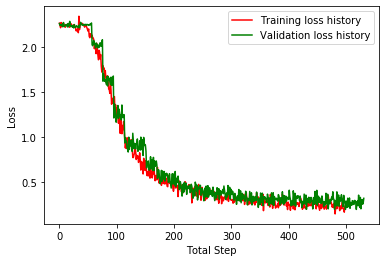

In [19]:
#plot training and validation loss history
import matplotlib.pyplot as plt
plt.plot(loss_train ,'r', label = 'Training loss history')
plt.plot(loss_val, 'g', label = 'Validation loss history')
plt.xlabel("Total Step")
plt.ylabel("Loss")
plt.legend()